# ESG Topic Classification Pipeline

So sánh 2 phương pháp:
1. **Zero-shot Classification**: Sử dụng mDeBERTa-v3-base-xnli
2. **Hierarchical Classification**: Weak supervision + PhoBERT

## Setup

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import json
from pathlib import Path
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
# Configuration
SELECTED_BANK = "vietcombank"
SELECTED_YEAR = 2024
SAMPLE_SIZE = 5000
RANDOM_SEED = 42

# Paths
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
INPUT_CSV = DATA_DIR / "all_banks_preprocessed_sentences.csv"
TAXONOMY_JSON = PROJECT_ROOT / "gri_topics.json"

# Create output directories
OUTPUT_DIR = PROJECT_ROOT / "results"
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Project Root: {PROJECT_ROOT}")
print(f"Data File: {INPUT_CSV}")
print(f"Taxonomy: {TAXONOMY_JSON}")

Project Root: /content
Data File: /content/data/all_banks_preprocessed_sentences.csv
Taxonomy: /content/gri_topics.json


## 1. Data Preparation

In [3]:
# Load taxonomy
with open(TAXONOMY_JSON, 'r', encoding='utf-8') as f:
    taxonomy = json.load(f)

print("GRI Taxonomy Structure:")
print(json.dumps(taxonomy, indent=2, ensure_ascii=False)[:500] + "...")
print(f"\nTaxonomy loaded: {len(taxonomy)} pillars")

GRI Taxonomy Structure:
{
  "E": {
    "categoryLabel": "Môi trường (Environment)",
    "topics": [
      {
        "key": "financedEmissions",
        "label": "Phát thải được tài trợ"
      },
      {
        "key": "climateRisk",
        "label": "Rủi ro Khí hậu",
        "subtopics": [
          {
            "key": "physicalRisk",
            "label": "Rủi ro Vật lý"
          },
          {
            "key": "transitionRisk",
            "label": "Rủi ro Chuyển đổi"
          }
        ]
      },
      {
       ...

Taxonomy loaded: 3 pillars


In [6]:
# Flatten taxonomy for classification
def flatten_taxonomy(taxonomy):
    """
    Chuyển taxonomy thành list các labels
    """
    labels = []
    label_to_pillar = {}

    for pillar, content in taxonomy.items():
        # Nếu có subtopics
        if isinstance(content, dict) and 'subtopics' in content:
            for subtopic in content['subtopics']:
                labels.append(subtopic)
                label_to_pillar[subtopic] = pillar
        # Nếu là dict nhưng không có subtopics (các subtopics là keys)
        elif isinstance(content, dict):
            for subtopic in content.keys():
                if subtopic != 'description':  # Skip description field
                    labels.append(subtopic)
                    label_to_pillar[subtopic] = pillar
        # Nếu là list
        elif isinstance(content, list):
            for subtopic in content:
                labels.append(subtopic)
                label_to_pillar[subtopic] = pillar

    # Add Non-ESG label
    labels.append("Non-ESG")
    label_to_pillar["Non-ESG"] = "Non-ESG"

    return labels, label_to_pillar

labels, label_to_pillar = flatten_taxonomy(taxonomy)
print(f"Total labels: {len(labels)}")
print(f"\nSample labels:")
for i, label in enumerate(labels[:10]):
    pillar = label_to_pillar[label]
    print(f"  {i+1}. {label} ({pillar})")
print("  ...")
print(f"\nTaxonomy flattened: {len(labels)} labels")

Total labels: 7

Sample labels:
  1. categoryLabel (G)
  2. topics (G)
  3. categoryLabel (G)
  4. topics (G)
  5. categoryLabel (G)
  6. topics (G)
  7. Non-ESG (Non-ESG)
  ...

Taxonomy flattened: 7 labels


In [7]:
# Load and filter data
print("Loading data...")
df = pd.read_csv(INPUT_CSV)
print(f"Total sentences: {len(df):,}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nSample data:")
df.head(3)

Loading data...
Total sentences: 130,359
Columns: ['bank', 'year', 'report_type', 'sentence_id', 'original_sentence', 'tokenized_sentence', 'cleaned_sentence', 'word_count', 'char_count']

Sample data:


,bank,year,report_type,sentence_id,original_sentence,tokenized_sentence,cleaned_sentence,word_count,char_count
0,agribank,2015,bctn,0,PB BÁO CÁO THƯỜNG NIÊN AGRIBANK 2015 MỤC LỤC T...,PB BÁO_CÁO THƯỜNG_NIÊN AGRIBANK 2015 MỤC_LỤC T...,pb báo_cáo thường_niên agribank 2015 mục_lục t...,9,63
1,agribank,2015,bctn,1,Thông điệp của Chủ tịch Hội đồng Thành viên AG...,Thông_điệp của Chủ_tịch Hội_đồng Thành_viên AG...,thông_điệp của chủ_tịch hội_đồng thành_viên ag...,11,86
2,agribank,2015,bctn,4,Quá trình hình thành và phát triển 16.,Quá_trình hình_thành và phát_triển 16 .,quá_trình hình_thành và phát_triển 16,5,37


In [8]:
# Filter by bank and year
df_filtered = df[
    (df['bank'] == SELECTED_BANK) &
    (df['year'] == SELECTED_YEAR)
].copy()

print(f"Filtered sentences: {len(df_filtered):,}")

# Sample if too large
if SAMPLE_SIZE and len(df_filtered) > SAMPLE_SIZE:
    df_filtered = df_filtered.sample(n=SAMPLE_SIZE, random_state=RANDOM_SEED)
    print(f"Sampled to: {len(df_filtered):,}")

# Reset index
df_filtered = df_filtered.reset_index(drop=True)

print(f"\nData prepared: {len(df_filtered):,} sentences")

Filtered sentences: 777

Data prepared: 777 sentences


## 2. Approach 1: Zero-Shot Classification

Sử dụng mDeBERTa-v3 với hierarchical approach

In [9]:
# Install transformers if needed
try:
    import transformers
    print(f"Transformers version: {transformers.__version__}")
except ImportError:
    print("Installing transformers...")
    !pip install transformers torch -q
    import transformers
    print(f"Transformers installed: {transformers.__version__}")

Transformers version: 4.57.1


In [10]:
from transformers import pipeline

# Load zero-shot model
print("Loading zero-shot classifier...")
MODEL_NAME = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"

classifier = pipeline(
    "zero-shot-classification",
    model=MODEL_NAME,
    device=0  # Use CPU (change to 0 for GPU)
)

print(f"Model loaded: {MODEL_NAME}")

Loading zero-shot classifier...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Device set to use cuda:0


Model loaded: MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7


In [54]:
# Classify all sentences (hierarchical)
def zero_shot_classify(sentence, classifier, taxonomy, target_topic_labels=None, threshold=0.5):
    """
    Classify sentence using zero-shot, optionally restricting to specific topics.
    If target_topic_labels is None, performs hierarchical classification (Pillar -> Subtopic).
    If target_topic_labels is a list of labels, classifies directly into those labels.
    """
    if target_topic_labels:
        # Direct classification into target topic labels
        result = classifier(sentence, target_topic_labels, multi_label=False)
        top_topic = result['labels'][0]
        topic_score = result['scores'][0]

        # Determine pillar based on taxonomy lookup
        # We need label_to_pillar mapping for this. Let's create it here or ensure it's global
        # For now, return Non-ESG as pillar if not found, or create mapping if needed.
        # Assuming label_to_pillar is available from flatten_taxonomy
        pillar = label_to_pillar.get(top_topic, "Non-ESG")


        return top_topic, pillar, 0.0, topic_score # Pillar confidence is 0 in direct classification

    else:
        # Hierarchical classification: Pillar → Subtopic (Existing logic)
        # Step 1: Classify pillar
        pillar_labels = list(taxonomy.keys()) + ["Non-ESG"]
        result = classifier(sentence, pillar_labels, multi_label=False)

        top_pillar = result['labels'][0]
        pillar_score = result['scores'][0]

        # If Non-ESG or low confidence, return Non-ESG
        if top_pillar == "Non-ESG" or pillar_score < threshold:
            return "Non-ESG", top_pillar, pillar_score, 0.0

        # Step 2: Classify subtopic
        pillar_content = taxonomy[top_pillar]
        if isinstance(pillar_content, dict) and 'topics' in pillar_content:
            subtopic_labels = [subtopic['label'] for subtopic in pillar_content['topics']]
        elif isinstance(pillar_content, dict):
             # Assuming keys (excluding 'description') are subtopics
            subtopic_labels = [k for k in pillar_content.keys() if k not in ['categoryLabel', 'topics']]
        elif isinstance(pillar_content, list):
            # Assuming list elements are subtopic dictionaries
            subtopic_labels = [subtopic['label'] for subtopic in pillar_content]
        else:
            subtopic_labels = []

        # Add Non-ESG if not already present
        if "Non-ESG" not in subtopic_labels:
             subtopic_labels.append("Non-ESG")


        if not subtopic_labels:
            return "Non-ESG", top_pillar, pillar_score, 0.0


        result2 = classifier(sentence, subtopic_labels, multi_label=False)
        top_subtopic = result2['labels'][0]
        subtopic_score = result2['scores'][0]

        return top_subtopic, top_pillar, pillar_score, subtopic_score

## 5. So sánh Original vs Cleaned Sentence

Kiểm tra hiệu quả của preprocessing

In [12]:
# Load original data with all columns
print("Loading original data with all sentence versions...")
df_full = pd.read_csv(INPUT_CSV)

# Filter same as before
df_full_filtered = df_full[
    (df_full['bank'].str.lower() == SELECTED_BANK.lower()) &
    (df_full['year'] == SELECTED_YEAR)
].copy()

if SAMPLE_SIZE and len(df_full_filtered) > SAMPLE_SIZE:
    # Use same random seed to get same samples
    df_full_filtered = df_full_filtered.sample(n=SAMPLE_SIZE, random_state=RANDOM_SEED)

df_full_filtered = df_full_filtered.reset_index(drop=True)

print(f"Loaded {len(df_full_filtered):,} sentences")
print(f"\nColumns: {df_full_filtered.columns.tolist()}")
print(f"\nSample data:")
print(df_full_filtered[['original_sentence', 'cleaned_sentence']].head(3))

Loading original data with all sentence versions...
Loaded 777 sentences

Columns: ['bank', 'year', 'report_type', 'sentence_id', 'original_sentence', 'tokenized_sentence', 'cleaned_sentence', 'word_count', 'char_count']

Sample data:
                                   original_sentence  \
0  | MỤC LỤC | Thông tin chung | 04 | Báo cáo của...   
1  Tăng trưởng kinh tế có cải thiện, nhưng sự phâ...   
2  Trong khi các nền kinh tế phát triển thu hút d...   

                                    cleaned_sentence  
0  mục_lục thông_tin chung 04 báo_cáo của ban tổn...  
1  tăng_trưởng kinh_tế có cải_thiện nhưng sự phân...  
2  trong khi các nền kinh_tế phát_triển thu_hút d...  


In [38]:
# Classify with ORIGINAL sentences
print("Classifying with ORIGINAL sentences...\n")

results_original = []

# Use the zero_shot_classify function
for i in tqdm(range(0, len(df_full_filtered)), desc="Original"):
    row = df_full_filtered.iloc[i]
    sentence = row['original_sentence']

    try:
        predicted_topic, pillar, pillar_conf, topic_conf = zero_shot_classify(
            sentence, classifier, taxonomy
        )

        results_original.append({
            'sentence': sentence,
            'predicted_topic': predicted_topic,
            'predicted_pillar': pillar,
            'pillar_confidence': pillar_conf,
            'topic_confidence': topic_conf
        })
    except Exception as e:
        print(f"Error processing sentence {i}: {str(e)}")
        results_original.append({
            'sentence': sentence,
            'predicted_topic': 'Non-ESG',
            'predicted_pillar': 'Non-ESG',
            'pillar_confidence': 0.0,
            'topic_confidence': 0.0
        })


df_original = pd.DataFrame(results_original)
print(f"\n✓ Original sentence classification complete: {len(df_original):,} results")

# Save original results
output_file_original = OUTPUT_DIR / f"zeroshot_original_{SELECTED_BANK}_{SELECTED_YEAR}_results.csv"
df_original.to_csv(output_file_original, index=False, encoding='utf-8-sig')
print(f"\nResults saved to: {output_file_original}")

Classifying with ORIGINAL sentences...



Original:   0%|          | 0/777 [00:00<?, ?it/s]


✓ Original sentence classification complete: 777 results

Results saved to: /content/results/zeroshot_original_vietcombank_2024_results.csv


In [39]:
# Classify with CLEANED sentences
print("Classifying with CLEANED sentences...\n")

results_cleaned = []

# Use the zero_shot_classify function
for i in tqdm(range(0, len(df_full_filtered)), desc="Cleaned"):
    row = df_full_filtered.iloc[i]
    sentence = row['cleaned_sentence']

    try:
        predicted_topic, pillar, pillar_conf, topic_conf = zero_shot_classify(
            sentence, classifier, taxonomy
        )

        results_cleaned.append({
            'sentence': sentence,
            'predicted_topic': predicted_topic,
            'predicted_pillar': pillar,
            'pillar_confidence': pillar_conf,
            'topic_confidence': topic_conf
        })
    except Exception as e:
        print(f"Error processing sentence {i}: {str(e)}")
        results_cleaned.append({
            'sentence': sentence,
            'predicted_topic': 'Non-ESG',
            'predicted_pillar': 'Non-ESG',
            'pillar_confidence': 0.0,
            'topic_confidence': 0.0
        })

df_cleaned = pd.DataFrame(results_cleaned)
print(f"\n✓ Cleaned sentence classification complete: {len(df_cleaned):,} results")

# Save cleaned results (if not already saved)
output_file_cleaned = OUTPUT_DIR / f"zeroshot_cleaned_{SELECTED_BANK}_{SELECTED_YEAR}_results.csv"
df_cleaned.to_csv(output_file_cleaned, index=False, encoding='utf-8-sig')
print(f"\nResults saved to: {output_file_cleaned}")

Classifying with CLEANED sentences...



Cleaned:   0%|          | 0/777 [00:00<?, ?it/s]


✓ Cleaned sentence classification complete: 777 results

Results saved to: /content/results/zeroshot_cleaned_vietcombank_2024_results.csv


In [15]:
# Compare Original vs Cleaned
print("="*80)
print("COMPARISON: ORIGINAL vs CLEANED SENTENCES")
print("="*80)

# Agreement rate
agreements = (df_original['predicted_topic'] == df_cleaned['predicted_topic']).sum()
agreement_rate = agreements / len(df_original) * 100

print(f"\nAgreement Rate: {agreement_rate:.2f}% ({agreements}/{len(df_original)})")

# Confidence comparison
print(f"\nAverage Confidence Scores:")
print(f"  Original - Pillar: {df_original['pillar_confidence'].mean():.3f}")
print(f"  Cleaned  - Pillar: {df_cleaned['pillar_confidence'].mean():.3f}")
print(f"  Original - Topic:  {df_original['topic_confidence'].mean():.3f}")
print(f"  Cleaned  - Topic:  {df_cleaned['topic_confidence'].mean():.3f}")

# Distribution comparison
print(f"\nPillar Distribution:")
print(f"\nOriginal:")
print(df_original['predicted_pillar'].value_counts())
print(f"\nCleaned:")
print(df_cleaned['predicted_pillar'].value_counts())

# Find disagreements
df_comparison = pd.DataFrame({
    'original_sentence': df_full_filtered['original_sentence'].head(100),
    'cleaned_sentence': df_full_filtered['cleaned_sentence'].head(100),
    'original_topic': df_original['predicted_topic'],
    'cleaned_topic': df_cleaned['predicted_topic'],
    'original_conf': df_original['topic_confidence'],
    'cleaned_conf': df_cleaned['topic_confidence'],
    'agreement': df_original['predicted_topic'] == df_cleaned['predicted_topic']
})

print(f"\n\nDisagreements (Original vs Cleaned):")
disagreements = df_comparison[df_comparison['agreement'] == False]
print(f"Total: {len(disagreements)}")
print(f"\nSample disagreements:")
for i, row in disagreements.head(5).iterrows():
    print(f"\n{i+1}. Original: {row['original_sentence'][:80]}...")
    print(f"   Cleaned:  {row['cleaned_sentence'][:80]}...")
    print(f"   → Original: {row['original_topic']} (conf: {row['original_conf']:.3f})")
    print(f"   → Cleaned:  {row['cleaned_topic']} (conf: {row['cleaned_conf']:.3f})")

COMPARISON: ORIGINAL vs CLEANED SENTENCES

Agreement Rate: 69.00% (69/100)

Average Confidence Scores:
  Original - Pillar: 0.498
  Cleaned  - Pillar: 0.505
  Original - Topic:  0.296
  Cleaned  - Topic:  0.363

Pillar Distribution:

Original:
predicted_pillar
S          76
E          12
Non-ESG     8
G           4
Name: count, dtype: int64

Cleaned:
predicted_pillar
S          86
E           7
G           4
Non-ESG     3
Name: count, dtype: int64


Disagreements (Original vs Cleaned):
Total: 31

Sample disagreements:

8. Original: Tổng doanh thu của Công ty đạt 1.519,7 tỷ đồng với tổng lợi nhuận trước thuế đạt...
   Cleaned:  tổng doanh_thu của công_ty đạt 1.519,7 tỷ đồng với tổng lợi_nhuận trước thuế đạt...
   → Original: Non-ESG (conf: 0.000)
   → Cleaned:  topics (conf: 0.782)

9. Original: Về thị phần kinh doanh, năm 2025, VCBS lọt top 10 Công ty Chứng khoán (CTCK) có ...
   Cleaned:  về thị_phần kinh_doanh năm 2025 vcbs lọt top 10 công_ty chứng_khoán ctck có thị_...
   → Original

Generating comparison visualizations...


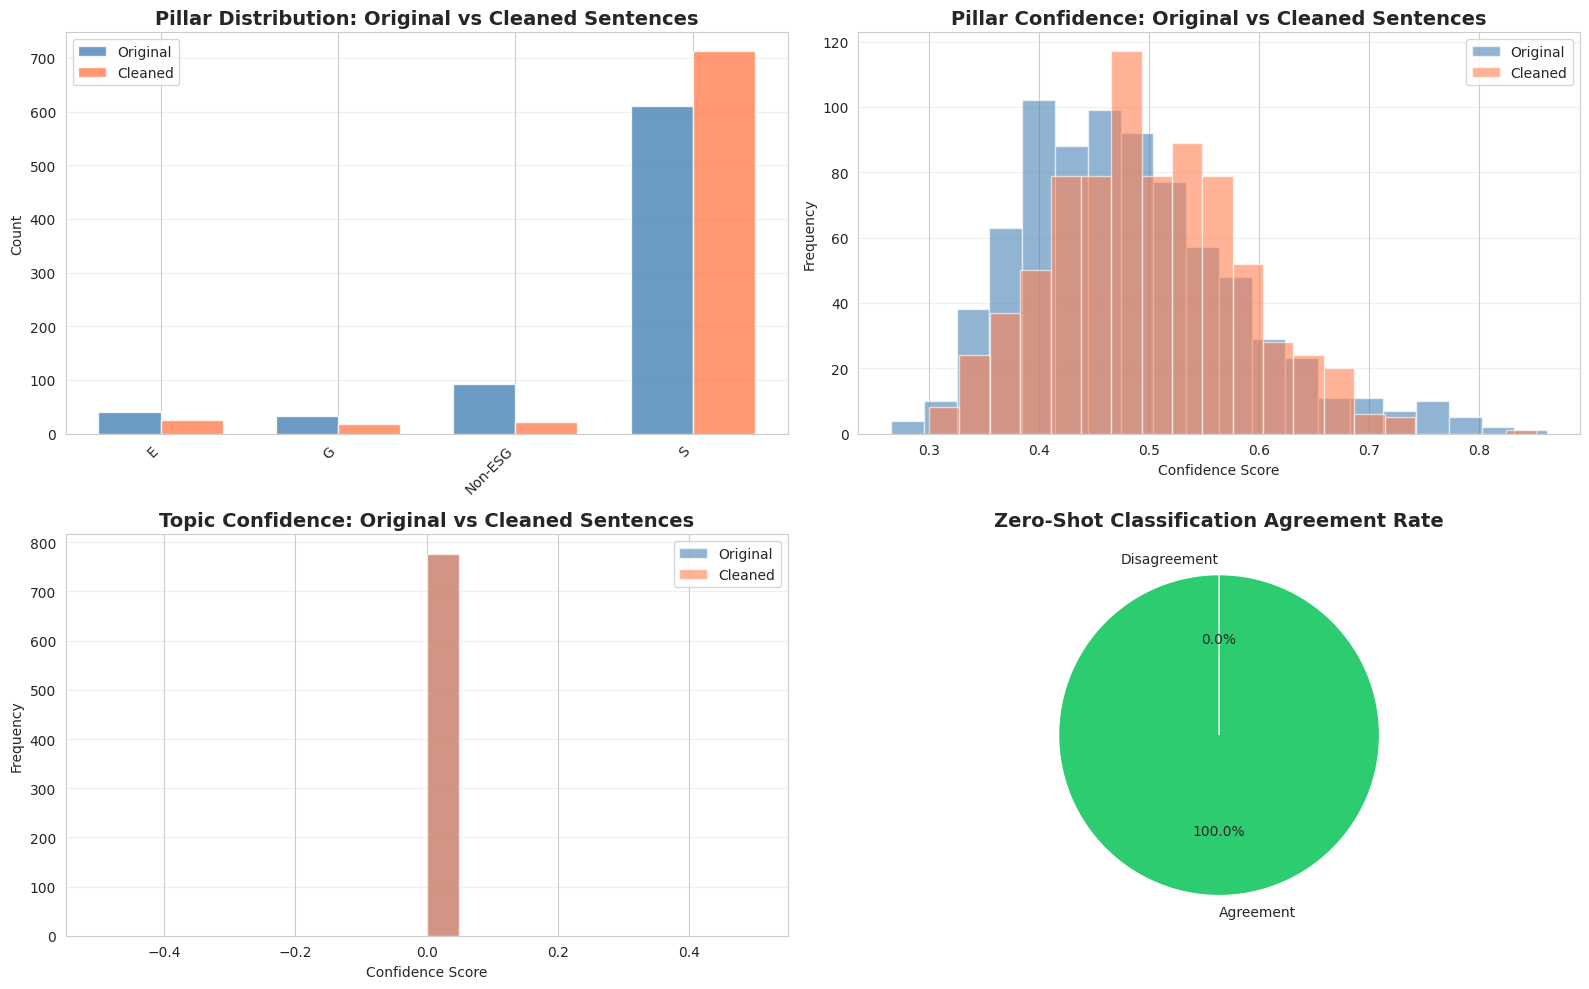

✓ Visualization saved: zeroshot_original_vs_cleaned_comparison.png


In [40]:
# Visualization: Original vs Cleaned Classification Results
print("Generating comparison visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Pillar distribution comparison
pillar_orig = df_original['predicted_pillar'].value_counts()
pillar_clean = df_cleaned['predicted_pillar'].value_counts()

# Ensure all pillars are present in both for consistent plotting
all_pillars = sorted(list(set(pillar_orig.index).union(set(pillar_clean.index))))
pillar_orig = pillar_orig.reindex(all_pillars, fill_value=0)
pillar_clean = pillar_clean.reindex(all_pillars, fill_value=0)


x = np.arange(len(all_pillars))
width = 0.35

axes[0, 0].bar(x - width/2, pillar_orig.values, width, label='Original', alpha=0.8, color='steelblue')
axes[0, 0].bar(x + width/2, pillar_clean.values, width, label='Cleaned', alpha=0.8, color='coral')
axes[0, 0].set_title('Pillar Distribution: Original vs Cleaned Sentences', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(all_pillars, rotation=45, ha='right')
axes[0, 0].set_ylabel('Count')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Confidence comparison - Pillar
axes[0, 1].hist(df_original['pillar_confidence'], bins=20, alpha=0.6, label='Original', color='steelblue')
axes[0, 1].hist(df_cleaned['pillar_confidence'], bins=20, alpha=0.6, label='Cleaned', color='coral')
axes[0, 1].set_title('Pillar Confidence: Original vs Cleaned Sentences', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Confidence Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Confidence comparison - Topic
axes[1, 0].hist(df_original['topic_confidence'], bins=20, alpha=0.6, label='Original', color='steelblue')
axes[1, 0].hist(df_cleaned['topic_confidence'], bins=20, alpha=0.6, label='Cleaned', color='coral')
axes[1, 0].set_title('Topic Confidence: Original vs Cleaned Sentences', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Confidence Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Agreement pie chart
agreements = (df_original['predicted_topic'] == df_cleaned['predicted_topic']).sum()
agreement_rate = agreements / len(df_original) * 100
agreement_data = [agreement_rate, 100 - agreement_rate]
colors = ['#2ecc71', '#e74c3c']
axes[1, 1].pie(agreement_data, labels=['Agreement', 'Disagreement'], autopct='%1.1f%%',
               colors=colors, startangle=90)
axes[1, 1].set_title('Zero-Shot Classification Agreement Rate', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'zeroshot_original_vs_cleaned_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved: zeroshot_original_vs_cleaned_comparison.png")

## 3. Zero-Shot Classification (Specific Topics)

Phân loại chi tiết hơn vào các topic con sử dụng mDeBERTa-v3.

In [55]:
# Define target topic labels for detailed classification
# You can manually specify a list of labels, or derive them from the taxonomy.
# Example: Classifying into topics under the 'Environment' pillar (E)

target_topic_labels = []

for pillar_key, pillar_content in taxonomy.items():
    if isinstance(pillar_content, dict):
        # Handle structure with 'topics' list
        if 'topics' in pillar_content and isinstance(pillar_content['topics'], list):
            for topic in pillar_content['topics']:
                if isinstance(topic, dict) and 'label' in topic:
                    target_topic_labels.append(topic['label'])
                    # Add subtopics if they exist
                    if 'subtopics' in topic and isinstance(topic['subtopics'], list):
                        for subtopic in topic['subtopics']:
                            if isinstance(subtopic, dict) and 'label' in subtopic:
                                target_topic_labels.append(subtopic['label'])
        # Handle structure where keys (excluding 'categoryLabel') are topics
        else:
             # Assuming keys (excluding 'categoryLabel') are subtopics or topics
            for topic_key, topic_content in pillar_content.items():
                if topic_key != 'categoryLabel':
                     # Try to get label if it's a dict with label
                    if isinstance(topic_content, dict) and 'label' in topic_content:
                         target_topic_labels.append(topic_content['label'])
                    else:
                        # Otherwise, use the key itself as the label
                        target_topic_labels.append(topic_key)


    elif isinstance(pillar_content, list):
        # Handle structure where pillar content is a list of topic dictionaries
        for topic in pillar_content:
            if isinstance(topic, dict) and 'label' in topic:
                target_topic_labels.append(topic['label'])
                # Add subtopics if they exist within this list structure
                if 'subtopics' in topic and isinstance(topic['subtopics'], list):
                    for subtopic in topic['subtopics']:
                        if isinstance(subtopic, dict) and 'label' in subtopic:
                            target_topic_labels.append(subtopic['label'])


# Remove duplicates and add "Non-ESG"
target_topic_labels = list(set(target_topic_labels))
if "Non-ESG" not in target_topic_labels:
    target_topic_labels.append("Non-ESG")

# Remove any potential None values that might have been added
target_topic_labels = [label for label in target_topic_labels if label is not None]


print(f"Defined {len(target_topic_labels)} target topic labels for detailed classification:")
print(target_topic_labels[:20]) # Display first 20 labels
print("...")

Defined 20 target topic labels for detailed classification:
['Vốn Tự nhiên & Đa dạng Sinh học', 'Tính độc lập của HĐQT', 'Minh bạch & Vận động Hành lang', 'Tài chính Xanh', 'Đạo đức Kinh doanh & Văn hóa Doanh nghiệp', 'Cấu trúc & Giám sát của Hội đồng Quản trị', 'Văn hóa Liêm chính', 'Chống Tham nhũng & Hối lộ', 'Quản lý Rủi ro Hệ thống', 'Rủi ro Vật lý', 'Dấu chân Hoạt động', 'Cơ hội & Tài chính Bền vững', 'Rủi ro Chuyển đổi', 'Cơ chế Thưởng phạt (Liên quan đến rủi ro)', 'Chống Rửa tiền & Tài trợ Khủng bố (AML & CTF)', 'Rủi ro Khí hậu', 'Trái phiếu Xanh/Xã hội/Bền vững', 'Phát thải được tài trợ', 'Năng lực giám sát rủi ro (Khí hậu, An ninh mạng)', 'Non-ESG']
...


In [56]:
# Classify cleaned sentences using the defined target topic labels
print("\nClassifying CLEANED sentences into specific topics...\n")

results_specific_topics = []

for i in tqdm(range(0, len(df_full_filtered)), desc="Specific Topics"):
    row = df_full_filtered.iloc[i]
    sentence = row['cleaned_sentence']

    try:
        # Use the zero_shot_classify function with the specific target topic labels
        # We pass None for the taxonomy argument as it's not needed for direct classification
        predicted_topic, pillar, pillar_conf, topic_conf = zero_shot_classify(
            sentence, classifier, None, target_topic_labels=target_topic_labels
        )

        results_specific_topics.append({
            'sentence': sentence,
            'predicted_topic': predicted_topic,
            'predicted_pillar': pillar, # This will be derived from the topic
            'pillar_confidence': pillar_conf, # This will be 0
            'topic_confidence': topic_conf
        })
    except Exception as e:
        print(f"Error processing sentence {i}: {str(e)}")
        results_specific_topics.append({
            'sentence': sentence,
            'predicted_topic': 'Non-ESG',
            'predicted_pillar': 'Non-ESG',
            'pillar_confidence': 0.0,
            'topic_confidence': 0.0
        })

df_specific_topics = pd.DataFrame(results_specific_topics)
print(f"\n✓ Specific topic classification complete: {len(df_specific_topics):,} results")

# Save results
output_file_specific = OUTPUT_DIR / f"zeroshot_cleaned_{SELECTED_BANK}_{SELECTED_YEAR}_specific_topics_results.csv"
df_specific_topics.to_csv(output_file_specific, index=False, encoding='utf-8-sig')
print(f"\nResults saved to: {output_file_specific}")


Classifying CLEANED sentences into specific topics...



Specific Topics:   0%|          | 0/777 [00:00<?, ?it/s]


✓ Specific topic classification complete: 777 results

Results saved to: /content/results/zeroshot_cleaned_vietcombank_2024_specific_topics_results.csv


## 4. Combine and Compare Zero-Shot Results

Kết hợp kết quả phân loại E, S, G và phân loại topic cụ thể, sau đó so sánh.

In [60]:
# Merge the two classification results
# Assuming df_cleaned contains the E, S, G classification results
# and df_specific_topics contains the specific topic classification results

# Rename columns for clarity before merging
df_cleaned_renamed = df_cleaned.rename(columns={
    'predicted_topic': 'zeroshot_pillar_prediction',
    'predicted_pillar': 'zeroshot_pillar_predicted_pillar', # Keep the original hierarchical pillar prediction
    'pillar_confidence': 'zeroshot_pillar_confidence',
    'topic_confidence': 'zeroshot_topic_confidence' # This was topic confidence in the E,S,G step
})

df_specific_topics_renamed = df_specific_topics.rename(columns={
    'predicted_topic': 'zeroshot_specific_topic_prediction',
    'predicted_pillar': 'zeroshot_specific_topic_predicted_pillar', # This is derived from topic lookup in specific step
    'pillar_confidence': 'zeroshot_specific_topic_pillar_confidence', # This is always 0 in specific step
    'topic_confidence': 'zeroshot_specific_topic_confidence'
})

# We need to make sure the sentences are aligned correctly.
# Assuming the order is the same after filtering and sampling.
# If not, merge on a unique identifier like 'sentence_id' from the original dataframe.
# Since df_full_filtered has the index reset and was used for both, we can merge based on index.
df_combined_zeroshot = df_full_filtered[['sentence_id', 'original_sentence', 'cleaned_sentence']].copy()

df_combined_zeroshot = df_combined_zeroshot.merge(
    df_cleaned_renamed[['zeroshot_pillar_prediction', 'zeroshot_pillar_predicted_pillar', 'zeroshot_pillar_confidence', 'zeroshot_topic_confidence']],
    left_index=True,
    right_index=True,
    how='left'
)

df_combined_zeroshot = df_combined_zeroshot.merge(
    df_specific_topics_renamed[['zeroshot_specific_topic_prediction', 'zeroshot_specific_topic_predicted_pillar', 'zeroshot_specific_topic_pillar_confidence', 'zeroshot_specific_topic_confidence']],
    left_index=True,
    right_index=True,
    how='left'
)


print(f"Combined DataFrame created with {len(df_combined_zeroshot)} rows.")
print("\nSample combined data:")
display(df_combined_zeroshot.head())

Combined DataFrame created with 777 rows.

Sample combined data:


,sentence_id,original_sentence,cleaned_sentence,zeroshot_pillar_prediction,zeroshot_pillar_predicted_pillar,zeroshot_pillar_confidence,zeroshot_topic_confidence,zeroshot_specific_topic_prediction,zeroshot_specific_topic_predicted_pillar,zeroshot_specific_topic_pillar_confidence,zeroshot_specific_topic_confidence
0,0,| MỤC LỤC | Thông tin chung | 04 | Báo cáo của...,mục_lục thông_tin chung 04 báo_cáo của ban tổn...,Non-ESG,S,0.599803,0.0,Cấu trúc & Giám sát của Hội đồng Quản trị,Non-ESG,0.0,0.123635
1,1,"Tăng trưởng kinh tế có cải thiện, nhưng sự phâ...",tăng_trưởng kinh_tế có cải_thiện nhưng sự phân...,Non-ESG,S,0.443439,0.0,Dấu chân Hoạt động,Non-ESG,0.0,0.126810
2,2,Trong khi các nền kinh tế phát triển thu hút d...,trong khi các nền kinh_tế phát_triển thu_hút d...,Non-ESG,S,0.482415,0.0,Dấu chân Hoạt động,Non-ESG,0.0,0.125947
3,3,"Các cuộc xung đột quân sự kéo dài, như Nga – U...",các cuộc xung_đột quân_sự kéo_dài như nga ukra...,Non-ESG,S,0.345605,0.0,Non-ESG,Non-ESG,0.0,0.244508
4,4,"Thị trường Chứng khoán Việt Nam, trước những t...",thị_trường_chứng_khoán việt_nam trước những th...,Non-ESG,S,0.534907,0.0,Dấu chân Hoạt động,Non-ESG,0.0,0.109494


In [61]:
# Add Actual Pillar column based on Taxonomy for Specific Topics
def get_actual_pillar(topic_label, taxonomy):
    """
    Looks up the actual pillar (E, S, G) for a given specific topic label from the taxonomy.
    Returns the pillar or 'Non-ESG' if not found.
    """
    # Flatten taxonomy to easily lookup label to pillar
    _, label_to_pillar = flatten_taxonomy(taxonomy) # Reuse flatten_taxonomy from above

    return label_to_pillar.get(topic_label, "Non-ESG")

print("Adding 'actual_pillar' column based on specific topic prediction...")

df_combined_zeroshot['actual_pillar'] = df_combined_zeroshot['zeroshot_specific_topic_prediction'].apply(
    lambda x: get_actual_pillar(x, taxonomy)
)

print("✓ 'actual_pillar' column added.")
print("\nSample data with 'actual_pillar':")
display(df_combined_zeroshot[['zeroshot_specific_topic_prediction', 'actual_pillar', 'zeroshot_pillar_prediction', 'zeroshot_pillar_predicted_pillar']].head())

Adding 'actual_pillar' column based on specific topic prediction...
✓ 'actual_pillar' column added.

Sample data with 'actual_pillar':


,zeroshot_specific_topic_prediction,actual_pillar,zeroshot_pillar_prediction,zeroshot_pillar_predicted_pillar
0,Cấu trúc & Giám sát của Hội đồng Quản trị,Non-ESG,Non-ESG,S
1,Dấu chân Hoạt động,Non-ESG,Non-ESG,S
2,Dấu chân Hoạt động,Non-ESG,Non-ESG,S
3,Non-ESG,Non-ESG,Non-ESG,S
4,Dấu chân Hoạt động,Non-ESG,Non-ESG,S


In [62]:
# Analysis and Comparison

print("="*80)
print("ZERO-SHOT CLASSIFICATION COMPARISON: PILLAR PREDICTION vs ACTUAL PILLAR")
print("="*80)

# Comparison of Zero-Shot Pillar Prediction vs Actual Pillar (derived from specific topic)
print("\nComparison: Zero-Shot Pillar Prediction vs Actual Pillar")
comparison_matrix = pd.crosstab(
    df_combined_zeroshot['zeroshot_pillar_predicted_pillar'], # Pillar predicted in the first step
    df_combined_zeroshot['actual_pillar'], # Actual pillar derived from the specific topic
    margins=True, # Add row/column sums
    normalize='index' # Normalize by row to see percentages
)
print("Normalized by predicted pillar (rows sum to 1):")
display(comparison_matrix.round(2))


comparison_matrix_total = pd.crosstab(
    df_combined_zeroshot['zeroshot_pillar_predicted_pillar'],
    df_combined_zeroshot['actual_pillar'],
    margins=True
)
print("\nTotal counts:")
display(comparison_matrix_total)


# Agreement Rate between Zero-Shot Pillar Prediction and Actual Pillar
agreement_count = (df_combined_zeroshot['zeroshot_pillar_predicted_pillar'] == df_combined_zeroshot['actual_pillar']).sum()
total_count = len(df_combined_zeroshot)
agreement_rate_pillars = agreement_count / total_count * 100

print(f"\nAgreement Rate (Zero-Shot Pillar Prediction vs Actual Pillar): {agreement_rate_pillars:.2f}% ({agreement_count}/{total_count})")


# Confidence analysis for specific topics vs pillars
print(f"\nConfidence Statistics:")
print(df_combined_zeroshot[['zeroshot_pillar_confidence', 'zeroshot_specific_topic_confidence']].describe())


# Disagreements analysis
print(f"\nAnalysis of Disagreements (where Zero-Shot Pillar Prediction != Actual Pillar):")
disagreements_pillars = df_combined_zeroshot[
    df_combined_zeroshot['zeroshot_pillar_predicted_pillar'] != df_combined_zeroshot['actual_pillar']
].copy()

print(f"Total Disagreements: {len(disagreements_pillars)}")

if not disagreements_pillars.empty:
    print(f"\nSample Disagreements (Pillar Prediction vs Actual Pillar):")
    for i, row in disagreements_pillars.head(5).iterrows():
        print(f"\n- Sentence ID: {row['sentence_id']}")
        print(f"  Cleaned Sentence: {row['cleaned_sentence'][:150]}...")
        print(f"  → Zero-Shot Pillar Prediction: {row['zeroshot_pillar_predicted_pillar']} (conf: {row['zeroshot_pillar_confidence']:.3f})")
        print(f"  → Specific Topic Prediction:   {row['zeroshot_specific_topic_prediction']} (conf: {row['zeroshot_specific_topic_confidence']:.3f})")
        print(f"  → Actual Pillar (from topic):    {row['actual_pillar']}")

else:
    print("  No disagreements found.")

ZERO-SHOT CLASSIFICATION COMPARISON: PILLAR PREDICTION vs ACTUAL PILLAR

Comparison: Zero-Shot Pillar Prediction vs Actual Pillar
Normalized by predicted pillar (rows sum to 1):


actual_pillar,Non-ESG
zeroshot_pillar_predicted_pillar,
E,1.0
G,1.0
Non-ESG,1.0
S,1.0
All,1.0



Total counts:


actual_pillar,Non-ESG,All
zeroshot_pillar_predicted_pillar,,
E,26,26
G,18,18
Non-ESG,21,21
S,712,712
All,777,777



Agreement Rate (Zero-Shot Pillar Prediction vs Actual Pillar): 2.70% (21/777)

Confidence Statistics:
       zeroshot_pillar_confidence  zeroshot_specific_topic_confidence
count                  777.000000                          777.000000
mean                     0.498484                            0.141084
std                      0.085225                            0.055054
min                      0.300336                            0.068253
25%                      0.436744                            0.104042
50%                      0.492099                            0.125806
75%                      0.554917                            0.161642
max                      0.851800                            0.547974

Analysis of Disagreements (where Zero-Shot Pillar Prediction != Actual Pillar):
Total Disagreements: 756

Sample Disagreements (Pillar Prediction vs Actual Pillar):

- Sentence ID: 0
  Cleaned Sentence: mục_lục thông_tin chung 04 báo_cáo của ban tổng_giám_đốc 48 thô

Generating comparison visualizations...


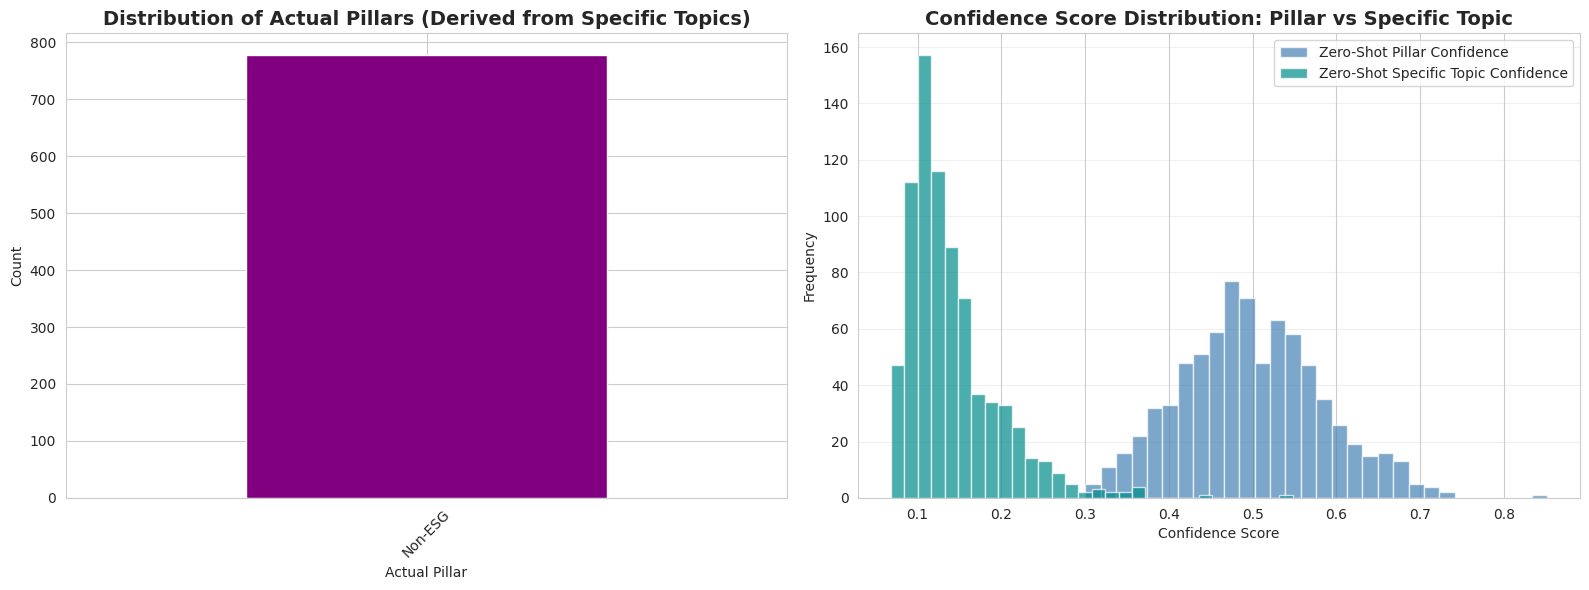

✓ Visualization saved: zeroshot_pillar_vs_actual_comparison.png


In [63]:
# Visualization of Comparison

print("Generating comparison visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution of Actual Pillar (derived from specific topic)
df_combined_zeroshot['actual_pillar'].value_counts().plot(kind='bar', ax=axes[0], color='purple')
axes[0].set_title('Distribution of Actual Pillars (Derived from Specific Topics)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Actual Pillar')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Confidence comparison (Pillar Prediction vs Specific Topic)
axes[1].hist(df_combined_zeroshot['zeroshot_pillar_confidence'], bins=30, alpha=0.7, label='Zero-Shot Pillar Confidence', color='steelblue')
axes[1].hist(df_combined_zeroshot['zeroshot_specific_topic_confidence'], bins=30, alpha=0.7, label='Zero-Shot Specific Topic Confidence', color='darkcyan')
axes[1].set_title('Confidence Score Distribution: Pillar vs Specific Topic', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Confidence Score')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'zeroshot_pillar_vs_actual_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved: zeroshot_pillar_vs_actual_comparison.png")

In [64]:
print("\n" + "="*80)
print("SUMMARY: ZERO-SHOT PILLAR PREDICTION vs ACTUAL PILLAR COMPARISON")
print("="*80)

print(f"\nTotal Sentences: {len(df_combined_zeroshot):,}")
print(f"Agreement Rate (Zero-Shot Pillar Prediction vs Actual Pillar): {agreement_rate_pillars:.2f}% ({agreement_count}/{total_count})")

print("\nComparison Matrix (Normalized by Predicted Pillar):")
display(comparison_matrix.round(2))

print("\nComparison Matrix (Total Counts):")
display(comparison_matrix_total)


print(f"\nAverage Confidence:")
print(f"  Zero-Shot Pillar Confidence: {df_combined_zeroshot['zeroshot_pillar_confidence'].mean():.3f}")
print(f"  Zero-Shot Specific Topic Confidence: {df_combined_zeroshot['zeroshot_specific_topic_confidence'].mean():.3f}")


print(f"\nOutput Files:")
print(f"  Combined Results CSV: N/A (DataFrame in memory)") # We can add saving here if needed
print(f"  Comparison Visualization: {OUTPUT_DIR / 'zeroshot_pillar_vs_actual_comparison.png'}")

print(f"\n{'='*80}")
print("NEXT STEPS")
print("="*80)
print("""
1. Analyze the comparison matrices to understand where the pillar predictions align or differ from the actual pillars (derived from specific topics).
2. Examine samples from key cells in the comparison matrix (e.g., where pillar prediction is E but actual is S) to understand the discrepancies.
3. Consider if the hierarchical classification in the first step (E,S,G) is necessary or if direct classification into specific topics is more effective.
4. Evaluate if the specific topic labels are granular enough or too granular for the task.
""")


SUMMARY: ZERO-SHOT PILLAR PREDICTION vs ACTUAL PILLAR COMPARISON

Total Sentences: 777
Agreement Rate (Zero-Shot Pillar Prediction vs Actual Pillar): 2.70% (21/777)

Comparison Matrix (Normalized by Predicted Pillar):


actual_pillar,Non-ESG
zeroshot_pillar_predicted_pillar,
E,1.0
G,1.0
Non-ESG,1.0
S,1.0
All,1.0



Comparison Matrix (Total Counts):


actual_pillar,Non-ESG,All
zeroshot_pillar_predicted_pillar,,
E,26,26
G,18,18
Non-ESG,21,21
S,712,712
All,777,777



Average Confidence:
  Zero-Shot Pillar Confidence: 0.498
  Zero-Shot Specific Topic Confidence: 0.141

Output Files:
  Combined Results CSV: N/A (DataFrame in memory)
  Comparison Visualization: /content/results/zeroshot_pillar_vs_actual_comparison.png

NEXT STEPS

1. Analyze the comparison matrices to understand where the pillar predictions align or differ from the actual pillars (derived from specific topics).
2. Examine samples from key cells in the comparison matrix (e.g., where pillar prediction is E but actual is S) to understand the discrepancies.
3. Consider if the hierarchical classification in the first step (E,S,G) is necessary or if direct classification into specific topics is more effective.
4. Evaluate if the specific topic labels are granular enough or too granular for the task.



In [57]:
# Analyze results for specific topic classification
print("Zero-Shot Classification Results (Specific Topics - Cleaned Sentences):\n")

print("Topic Distribution:")
specific_topic_counts = df_specific_topics['predicted_topic'].value_counts()
print(specific_topic_counts.head(20)) # Display top 20 specific topics

print(f"\nPillar Distribution (Derived from Topics):")
specific_pillar_counts = df_specific_topics['predicted_pillar'].value_counts()
print(specific_pillar_counts)


print(f"\nConfidence Statistics (Topic Confidence):")
print(df_specific_topics['topic_confidence'].describe())

# Note: pillar_confidence will be 0 for direct topic classification

Zero-Shot Classification Results (Specific Topics - Cleaned Sentences):

Topic Distribution:
predicted_topic
Phát thải được tài trợ                           212
Dấu chân Hoạt động                               176
Cơ chế Thưởng phạt (Liên quan đến rủi ro)         65
Non-ESG                                           52
Cấu trúc & Giám sát của Hội đồng Quản trị         49
Quản lý Rủi ro Hệ thống                           49
Cơ hội & Tài chính Bền vững                       49
Chống Rửa tiền & Tài trợ Khủng bố (AML & CTF)     26
Minh bạch & Vận động Hành lang                    23
Văn hóa Liêm chính                                17
Rủi ro Chuyển đổi                                 15
Chống Tham nhũng & Hối lộ                         14
Trái phiếu Xanh/Xã hội/Bền vững                    9
Tính độc lập của HĐQT                              9
Tài chính Xanh                                     6
Đạo đức Kinh doanh & Văn hóa Doanh nghiệp          3
Vốn Tự nhiên & Đa dạng Sinh học            

Generating visualizations for Specific Topics results (Cleaned Sentences)...


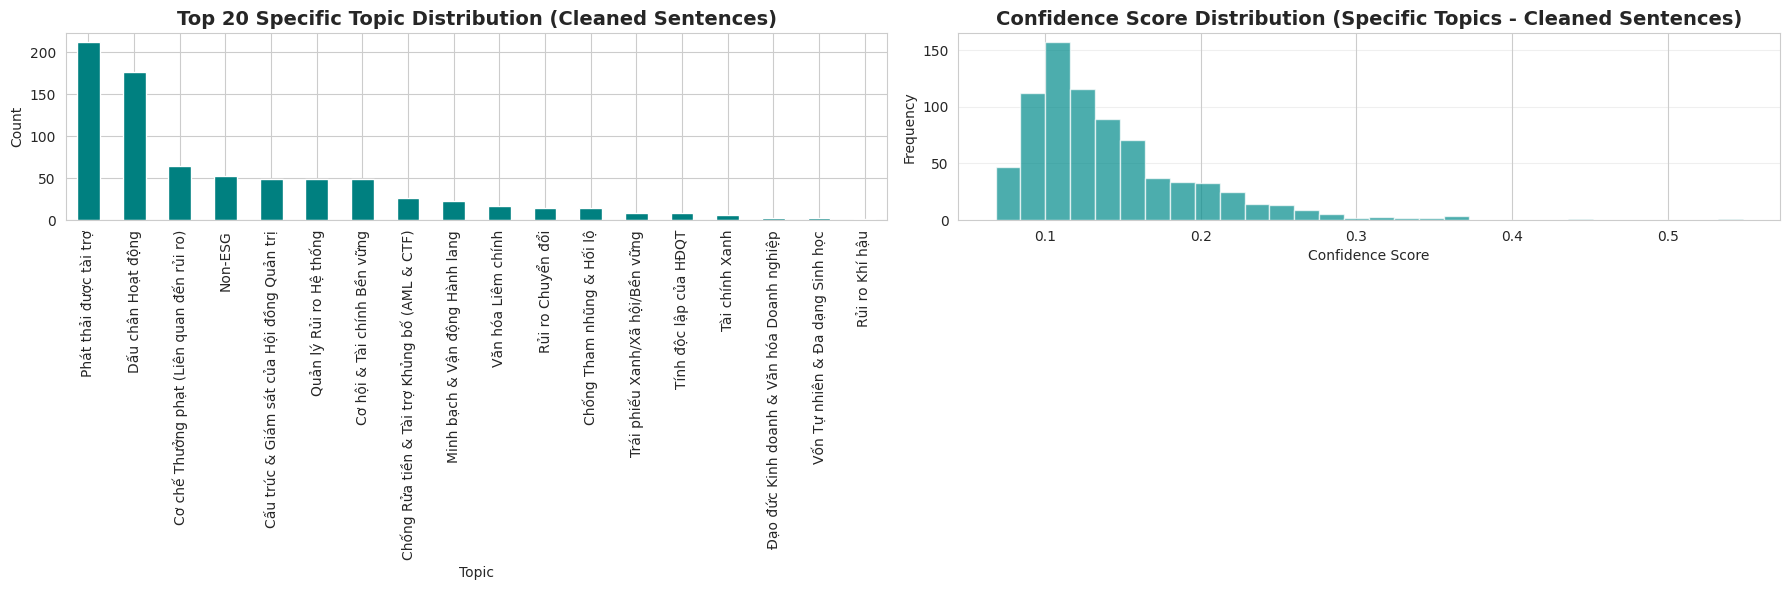

✓ Visualization saved: zeroshot_cleaned_specific_topics_distribution.png


In [58]:
# Visualization for specific topic classification results
print("Generating visualizations for Specific Topics results (Cleaned Sentences)...")

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Topic distribution (Top 20)
specific_topic_counts.head(20).plot(kind='bar', ax=axes[0], color='teal')
axes[0].set_title('Top 20 Specific Topic Distribution (Cleaned Sentences)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Topic')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=90)

# Confidence distribution (Topic Confidence)
axes[1].hist(df_specific_topics['topic_confidence'], bins=30, alpha=0.7, color='darkcyan')
axes[1].set_title('Confidence Score Distribution (Specific Topics - Cleaned Sentences)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Confidence Score')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y', alpha=0.3)


plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'zeroshot_cleaned_specific_topics_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved: zeroshot_cleaned_specific_topics_distribution.png")

In [59]:
print("\n" + "="*80)
print("SUMMARY: ZERO-SHOT CLASSIFICATION (SPECIFIC TOPICS - CLEANED SENTENCES)")
print("="*80)

print(f"\nBank: {SELECTED_BANK}")
print(f"Year: {SELECTED_YEAR}")
print(f"Total Sentences: {len(df_specific_topics):,}")

print(f"\nSpecific Topic Classification Results (Top 10):")
for topic, count in specific_topic_counts.head(10).items():
    pct = count / len(df_specific_topics) * 100
    print(f"  {topic:30s}: {count:4d} ({pct:5.1f}%)")

print(f"\nDerived Pillar Distribution:")
for pillar, count in specific_pillar_counts.items():
    pct = count / len(df_specific_topics) * 100
    print(f"  {pillar}: {count:,} ({pct:.1f}%)")

print(f"\nAverage Topic Confidence:")
print(f"  Topic: {df_specific_topics['topic_confidence'].mean():.3f}")

print(f"\nOutput Files:")
print(f"  Results CSV: {output_file_specific}")
print(f"  Visualization: {OUTPUT_DIR / 'zeroshot_cleaned_specific_topics_distribution.png'}")

print(f"\n{'='*80}")
print("NEXT STEPS")
print("="*80)
print("""
1. Review the specific topic distribution to see if it aligns with expectations.
2. Examine sentences classified under specific high-frequency topics.
3. Analyze sentences classified as "Non-ESG" in this more detailed classification.
4. Consider adjusting the list of target topic labels if needed.
""")


SUMMARY: ZERO-SHOT CLASSIFICATION (SPECIFIC TOPICS - CLEANED SENTENCES)

Bank: vietcombank
Year: 2024
Total Sentences: 777

Specific Topic Classification Results (Top 10):
  Phát thải được tài trợ        :  212 ( 27.3%)
  Dấu chân Hoạt động            :  176 ( 22.7%)
  Cơ chế Thưởng phạt (Liên quan đến rủi ro):   65 (  8.4%)
  Non-ESG                       :   52 (  6.7%)
  Cấu trúc & Giám sát của Hội đồng Quản trị:   49 (  6.3%)
  Quản lý Rủi ro Hệ thống       :   49 (  6.3%)
  Cơ hội & Tài chính Bền vững   :   49 (  6.3%)
  Chống Rửa tiền & Tài trợ Khủng bố (AML & CTF):   26 (  3.3%)
  Minh bạch & Vận động Hành lang:   23 (  3.0%)
  Văn hóa Liêm chính            :   17 (  2.2%)

Derived Pillar Distribution:
  Non-ESG: 777 (100.0%)

Average Topic Confidence:
  Topic: 0.141

Output Files:
  Results CSV: /content/results/zeroshot_cleaned_vietcombank_2024_specific_topics_results.csv
  Visualization: /content/results/zeroshot_cleaned_specific_topics_distribution.png

NEXT STEPS

1. Revie